# **INFERENCE**
___
___

## **INITIALIZATION**

### *IMPORTS*

In [72]:
from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys

from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import torch
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.utils as vutils

### *DATA LOADING*

In [73]:
train_df = pd.read_csv("train.csv", index_col=0, names=["val1", "val2", "val3", "val4"])

In [74]:
display(train_df)

,val1,val2,val3,val4
0,0.012495,0.011126,0.003252,0.006625
1,0.011439,0.002691,0.001206,0.006947
2,0.000632,0.007277,0.004049,0.000074
3,0.017828,0.028210,0.007758,0.007382
4,0.021115,0.019642,0.009238,0.011499
...,...,...,...,...
741,0.001938,0.008833,0.003927,0.005106
742,0.005003,0.018943,0.003057,0.001988
743,0.007683,0.001958,0.007002,0.006467
744,0.003396,0.001280,0.007621,0.001680


___

## **DATA PREPROCESSING**

### *DATA NORMALIZATION*

In [75]:
train_df_normalized = (train_df-train_df.mean())/train_df.std()

In [76]:
display(train_df_normalized)

,val1,val2,val3,val4
0,-0.054470,-0.144799,-0.658635,-0.445863
1,-0.143146,-0.864998,-0.878996,-0.411402
2,-1.050247,-0.473369,-0.572821,-1.147324
3,0.393122,1.313894,-0.173239,-0.364766
4,0.668991,0.582378,-0.013851,0.076110
...,...,...,...,...
741,-0.940601,-0.340562,-0.585969,-0.608536
742,-0.683350,0.522619,-0.679619,-0.942462
743,-0.458394,-0.927581,-0.254648,-0.462799
744,-0.818257,-0.985469,-0.188021,-0.975389


### *DATA VISUALIZATION*

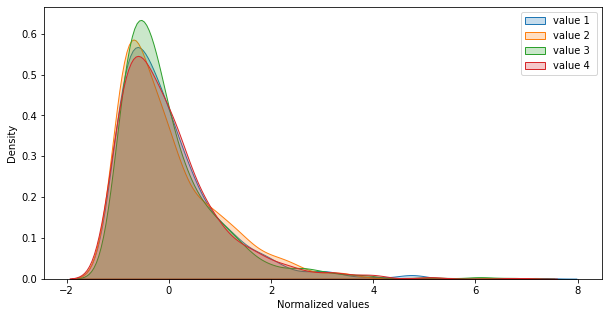

In [77]:
plt.figure(figsize=(10,5))
for column in train_df_normalized.columns:
    sns.kdeplot(train_df_normalized[column], shade=True)
plt.xlabel("Normalized values")
plt.legend(labels=["value 1", "value 2 ", "value 3", "value 4"])
plt.show()

___

## **Basic GAN**

Based on this [GitHub tutorial](https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/2019-04-23%20GAN%20Tutorial.ipynb).

### *DEFINING THE NEURAL NETWORKS*

In [78]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device: {}".format(device))

device: cuda


In [ ]:
class Disciminator(nn.Module):

    def __init__(self, input_size=4):
        super(Disciminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.nl1 = nn.LeakyReLU(0.25)
        self.fc2 = nn.Linear(64, 16)
        self.nl2 = nn.LeakyReLU(0.125)
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        o = self.nl1(self.fc1(x))
        o = self.nl2(self.fc2(o))
        return torch.sigmoid(self.fc3(o))

In [ ]:
class Generator(nn.Module):

    def __init__(self, z_size=50):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_size, 16)
        self.nl1 = nn.LeakyReLU(0.25)
        self.fc2 = nn.Linear(16, 64)
        self.nl2 = nn.LeakyReLU(0.125)
        self.fc3 = nn.Linear(64, 4)
    
    def forward(self, x):
        o = self.nl1(self.fc1(x))
        o = self.nl2(self.fc2(o))
        return self.fc3(o)
        

In [ ]:
D = Disciminator().to(device)
print(D)

G = Generator().to(device)
print(G)

Disciminator(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (nl1): LeakyReLU(negative_slope=0.25)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (nl2): LeakyReLU(negative_slope=0.125)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=10, out_features=8, bias=True)
  (nl1): LeakyReLU(negative_slope=0.25)
  (fc2): Linear(in_features=8, out_features=16, bias=True)
  (nl2): LeakyReLU(negative_slope=0.125)
  (fc3): Linear(in_features=16, out_features=4, bias=True)
)


### *TESTING THE NEURAL NETWORKS*

In [ ]:
samples = torch.randn(5, 4).to(device)
D(samples)

tensor([[0.3899],
        [0.4237],
        [0.4017],
        [0.4022],
        [0.4164]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [152]:
z_samples = torch.randn(5, 10).to(device)
G(z_samples)

tensor([[-0.1781,  0.0817, -0.3433, -0.2929],
        [ 0.0202, -0.0869, -0.2070,  0.0981],
        [-0.0808, -0.0605, -0.1386, -0.0326],
        [-0.0849, -0.1652, -0.1612,  0.2293],
        [-0.0080, -0.0725, -0.2483,  0.0647]], device='cuda:0',
       grad_fn=<AddmmBackward>)

### *DATASET LOADING*

In [153]:
batch_size = 25

features = torch.tensor(train_df_normalized.values).to(device)
true_targets = torch.ones((features.shape[0],1)).to(device)
fake_targets = torch.zeros((features.shape[0],1)).to(device)

train_ds = data_utils.TensorDataset(features, true_targets)
train_ds_loader = data_utils.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

### *TRAINING THE NETWORKS*

In [154]:
optimizerD = optim.SGD(D.parameters(), lr=0.05)
optimizerG = optim.SGD(G.parameters(), lr=0.05)

In [155]:
criterion = nn.BCELoss()
n_epochs = 10000
fixed_noise = torch.randn(batch_size, 10).to(device)
collect_x_gen = []

In [156]:
torch.randn(10, 4).dtype

torch.float32

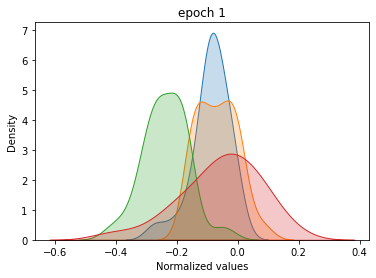

e0 / last mb D(x)=30.0000 D(G(z))=0.4683


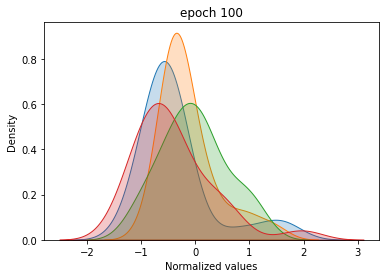

e99 / last mb D(x)=30.0000 D(G(z))=0.5055


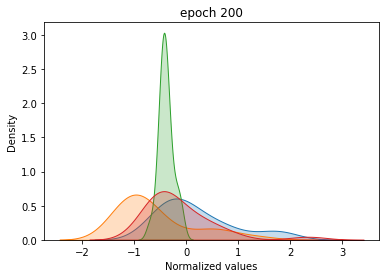

e199 / last mb D(x)=30.0000 D(G(z))=0.4670


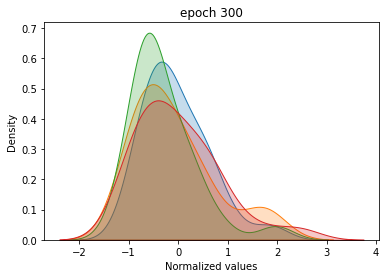

e299 / last mb D(x)=30.0000 D(G(z))=0.4978


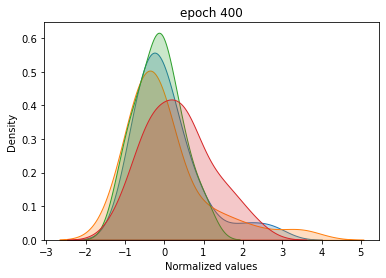

e399 / last mb D(x)=30.0000 D(G(z))=0.4869


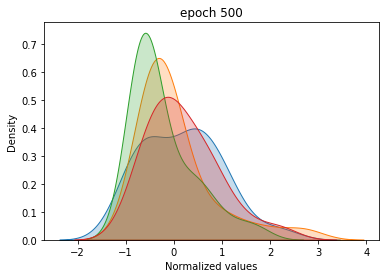

e499 / last mb D(x)=30.0000 D(G(z))=0.4949


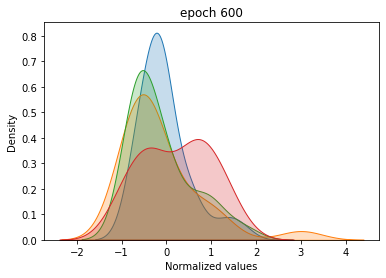

e599 / last mb D(x)=30.0000 D(G(z))=0.5114


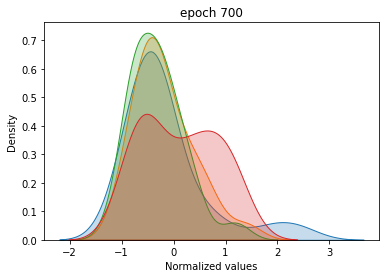

e699 / last mb D(x)=30.0000 D(G(z))=0.4856


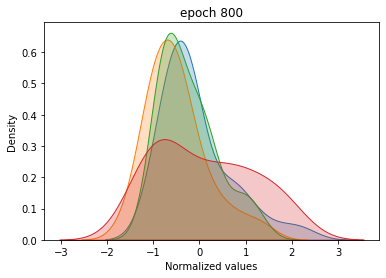

e799 / last mb D(x)=30.0000 D(G(z))=0.5221


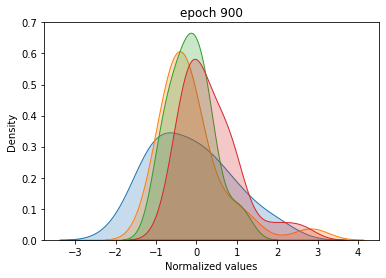

e899 / last mb D(x)=30.0000 D(G(z))=0.5112


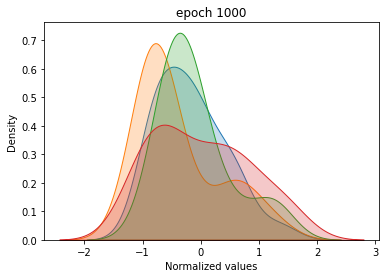

e999 / last mb D(x)=30.0000 D(G(z))=0.5173


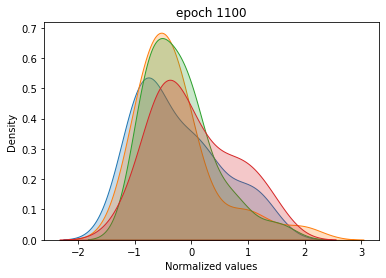

e1099 / last mb D(x)=30.0000 D(G(z))=0.4988


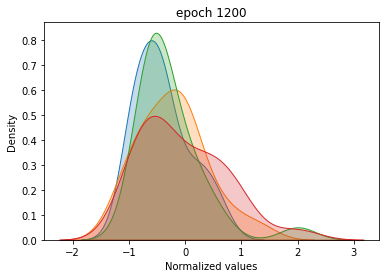

e1199 / last mb D(x)=30.0000 D(G(z))=0.5259


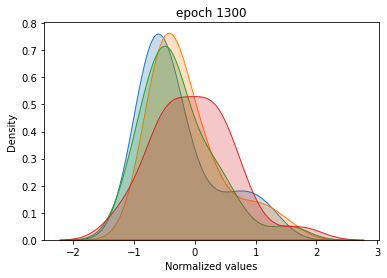

e1299 / last mb D(x)=30.0000 D(G(z))=0.5052


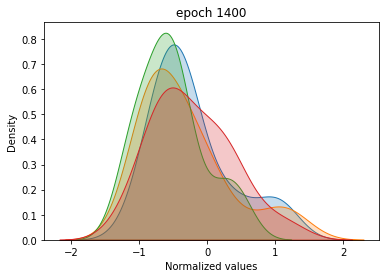

e1399 / last mb D(x)=30.0000 D(G(z))=0.4863


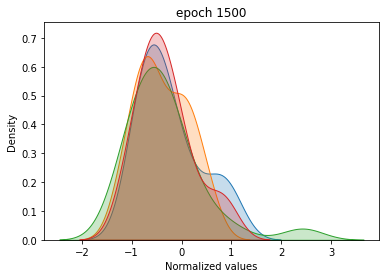

e1499 / last mb D(x)=30.0000 D(G(z))=0.4851


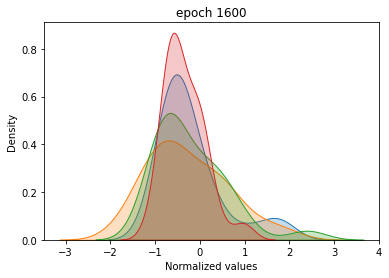

e1599 / last mb D(x)=30.0000 D(G(z))=0.4878


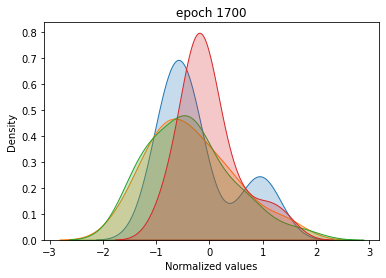

e1699 / last mb D(x)=30.0000 D(G(z))=0.4975


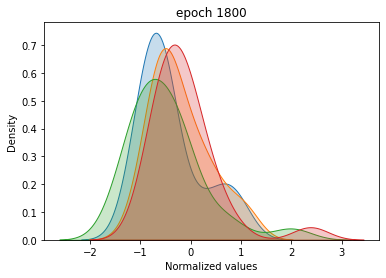

e1799 / last mb D(x)=30.0000 D(G(z))=0.5176


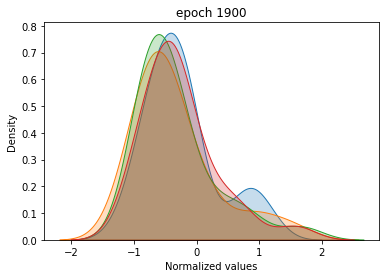

e1899 / last mb D(x)=30.0000 D(G(z))=0.5047


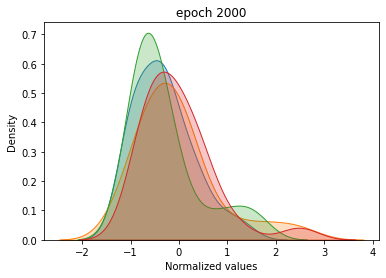

e1999 / last mb D(x)=30.0000 D(G(z))=0.4916


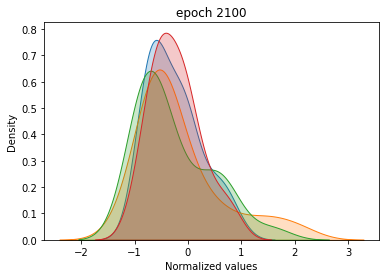

e2099 / last mb D(x)=30.0000 D(G(z))=0.4910


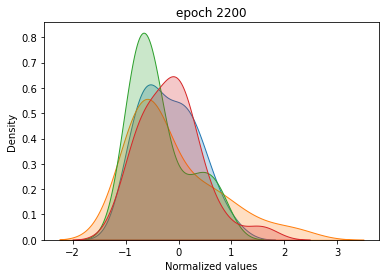

e2199 / last mb D(x)=30.0000 D(G(z))=0.5042


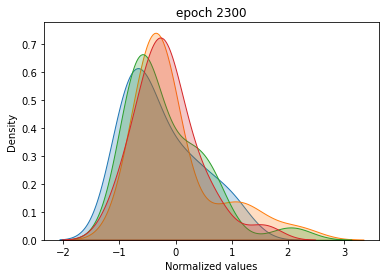

e2299 / last mb D(x)=30.0000 D(G(z))=0.5226


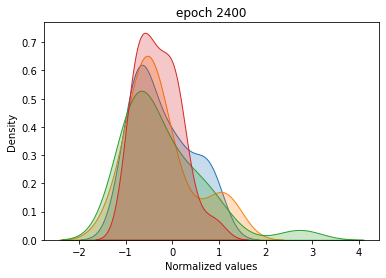

e2399 / last mb D(x)=30.0000 D(G(z))=0.5068


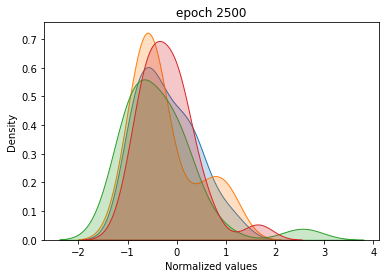

e2499 / last mb D(x)=30.0000 D(G(z))=0.4969


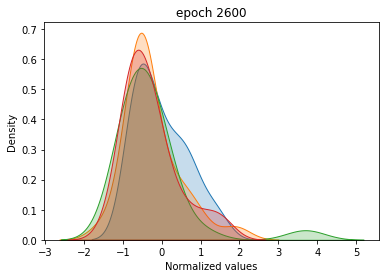

e2599 / last mb D(x)=30.0000 D(G(z))=0.5072


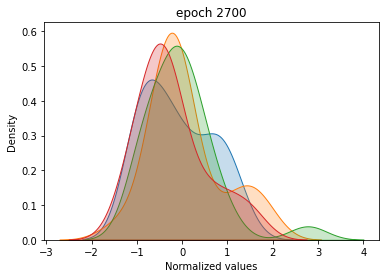

e2699 / last mb D(x)=30.0000 D(G(z))=0.5056


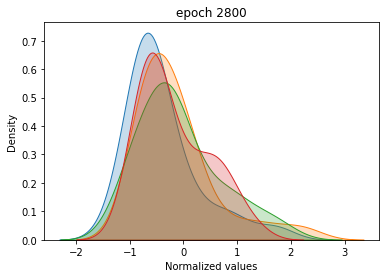

e2799 / last mb D(x)=30.0000 D(G(z))=0.4951


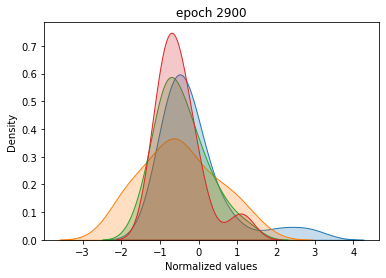

e2899 / last mb D(x)=30.0000 D(G(z))=0.4901


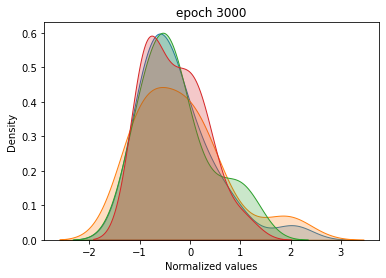

e2999 / last mb D(x)=30.0000 D(G(z))=0.4779


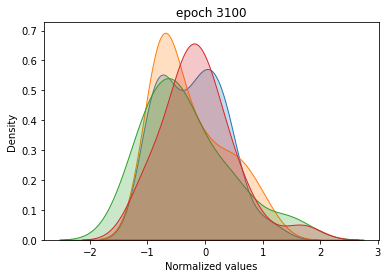

e3099 / last mb D(x)=30.0000 D(G(z))=0.5265


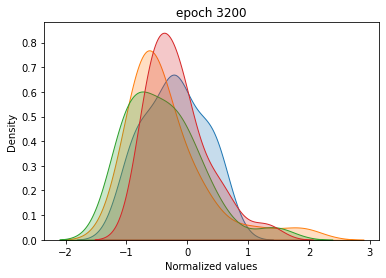

e3199 / last mb D(x)=30.0000 D(G(z))=0.5088


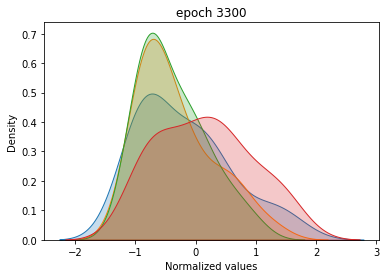

e3299 / last mb D(x)=30.0000 D(G(z))=0.4959


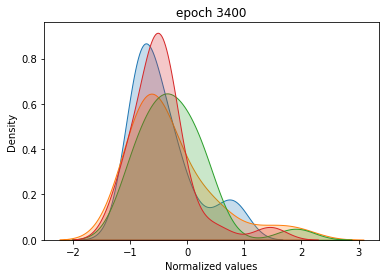

e3399 / last mb D(x)=30.0000 D(G(z))=0.4983


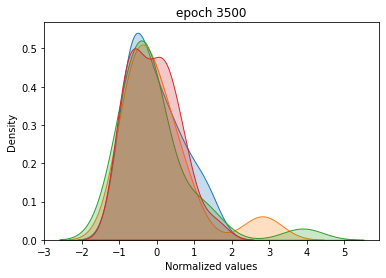

e3499 / last mb D(x)=30.0000 D(G(z))=0.5307


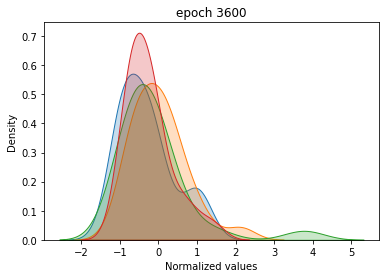

e3599 / last mb D(x)=30.0000 D(G(z))=0.4877


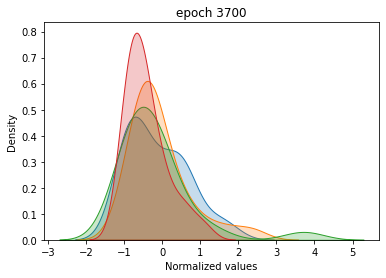

e3699 / last mb D(x)=30.0000 D(G(z))=0.4922


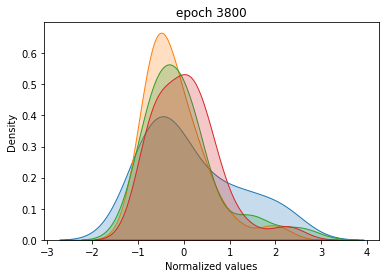

e3799 / last mb D(x)=30.0000 D(G(z))=0.5150


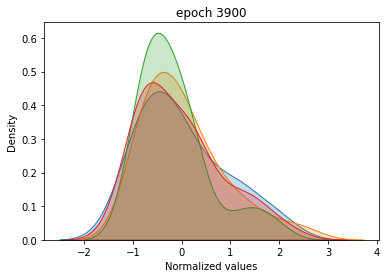

e3899 / last mb D(x)=30.0000 D(G(z))=0.5009


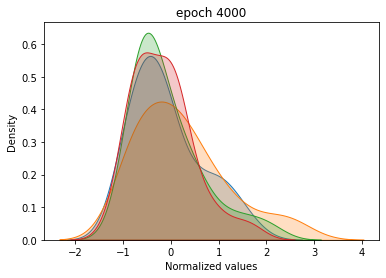

e3999 / last mb D(x)=30.0000 D(G(z))=0.4915


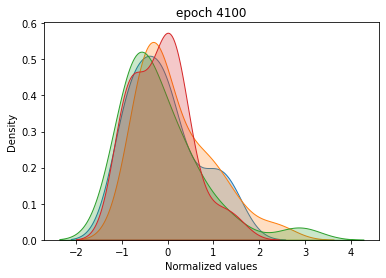

e4099 / last mb D(x)=30.0000 D(G(z))=0.5025


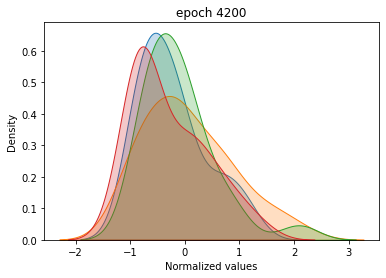

e4199 / last mb D(x)=30.0000 D(G(z))=0.5010


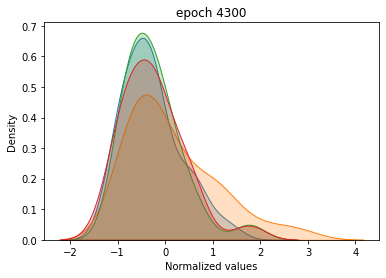

e4299 / last mb D(x)=30.0000 D(G(z))=0.5097


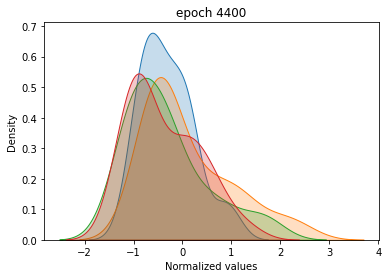

e4399 / last mb D(x)=30.0000 D(G(z))=0.4974


In [157]:
for epoch in range(n_epochs):

    for i,data in enumerate(train_ds_loader, 0):

        # STEP 1 : Discriminator optimization step

        optimizerD.zero_grad()

        x_real, y_real = iter(train_ds_loader).next()
        x_real = x_real.float()
        D_x_real = D(x_real)
        lossD_real = criterion(D_x_real, torch.ones((x_real.shape[0],1)).to(device))

        z = torch.randn(batch_size, 10).to(device)
        x_gen = G(z).detach()
        D_x_gen = D(x_gen)
        lossD_fake = criterion(D_x_gen, torch.zeros((x_gen.shape[0],1)).to(device))

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # STEP 2 : Discriminator optimization step

        optimizerG.zero_grad()

        z = torch.randn(batch_size, 10).to(device)
        x_gen = G(z)
        
        D_x_gen = D(x_gen)
        lossG = criterion(D_x_gen, torch.ones((x_gen.shape[0],1)).to(device))

        lossG.backward()
        optimizerG.step()

    if (epoch+1)%100 == 0 or epoch==0:
        x_gen = G(fixed_noise)
        x_gen_df = pd.DataFrame(x_gen.cpu().detach().numpy())
        for column in x_gen_df.columns:
            sns.kdeplot(x_gen_df[column], shade=True)
        plt.title("epoch {}".format(epoch+1))
        plt.xlabel("Normalized values")
        plt.show()
        print("e{} / last mb D(x)={:.4f} D(G(z))={:.4f}".format(
            epoch, len(train_ds_loader), D_x_real.mean().item(), D_x_gen.mean().item()
        ))
    
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())